In [12]:
import pandas as pd
import pickle
import seaborn as sns
import time
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import load_digits
from scipy.spatial.distance import pdist
from sklearn.manifold._t_sne import _joint_probabilities
from sklearn.metrics import pairwise_distances
from scipy.spatial.distance import squareform
from sklearn.manifold import TSNE
from matplotlib import pyplot as plt
import seaborn as sns
palette = sns.color_palette("bright", 10)
from sklearn.decomposition import PCA
import faiss
from sklearn.cluster import KMeans
import random
from PIL import Image

TSNE AND PCA for Extracted Features

In [2]:
def read_file(path):

    """
        Inputs: Feature File Path
        Ouputs: A Dataframe with File Name and corresponding Extracted Feature List
    """
    
    file_dict = pd.read_pickle(path)
    df = pd.DataFrame(file_dict.items(),columns=['Name','Feature_Value'])
    return df
    
def read_file_each_feature(path):

    """
        Inputs: Feature file Path
        Ouputs: A Dataframe with file names and extracted features(Each feature has a separate column)
    """
    
    file_dict = pd.read_pickle(path)
    df = pd.DataFrame(file_dict.items(),columns=['Name','Feature_Value'])
    columns = []
    for i in range(1024):
        columns = columns + [str(i)]
    df_final = pd.DataFrame(df['Feature_Value'].to_list(),columns = columns)
    df_final['Name'] = df['Name']
  
    return df_final

def dataset_labels(csv_file_path):
    """
        Inputs: Data CSV file with labels
        Outputs: a dictionary with labels and sample ids.
    """

    labels_df = pd.read_csv(csv_file_path)
    labels_df = labels_df.dropna()
    labels_df.astype(int)
    labels_dict = {}
    files_list = labels_df['Sample ID'].to_list()
    grade = labels_df['Sample Grade'].to_list()

    for i in range(len(files_list)):
        labels_dict[int(files_list[i])] = int(grade[i])
    
    return labels_dict

In [3]:
# df = read_file('/content/drive/MyDrive/MITACS/FineTuned_Model_Features_dict.pickle')
df = read_file_each_feature('/mnt/largedrive0/katariap/feature_extraction/data/Dataset/kimianet_features/FineTuned_Model_Features_dict.pickle')
labels_dict = dataset_labels('/mnt/largedrive0/katariap/feature_extraction/data/Dataset/Data.csv')

In [5]:
file_names = df['Name'].to_list() # Get the list of Patches Names(File Paths)

In [ ]:
# ((file_names[0]).split(' ')[1]).split('.')[0] # Extracting Sample ID from whole File Path

'362'

In [ ]:
# seq_list = []
# for name in file_names:

#     if ((name).split(' ')[1]).split('.')[0] == '632':
#         seq_list = seq_list + [name]


In [ ]:
#Add Grade Column to the dataframe and Add entries to the column for each image patch

df['Grade'] = ""
i = 0
list_Temp = df['Name'].to_list()
label_list = []
for patch in list_Temp:
    label = labels_dict[int(((patch).split(' ')[1]).split('.')[0])]
    label_list = label_list + [label]
    # print(len(label_list))

In [7]:
df['Grade'] = label_list

In [8]:
X = []  # Get the Extracted Feature List for Each Image Patch
for i in range(len(label_list)):
    X = X + [((df.iloc[i]).values.flatten().tolist())[:1024]]

In [9]:
tsne = TSNE()
X_embedded = tsne.fit_transform(X)

#ETF 7 minutes

/mnt/largedrive0/katariap/feature_extraction/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/mnt/largedrive0/katariap/feature_extraction/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


/mnt/largedrive0/katariap/feature_extraction/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:>

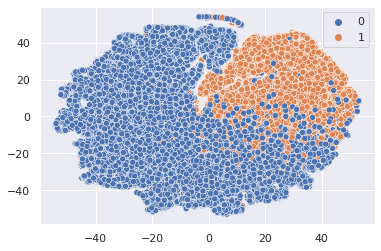

In [10]:
# TSNE Visualization
sns.scatterplot(X_embedded[:,0], X_embedded[:,1], hue=label_list, legend='full')

In [11]:
np.random.seed(42)
rndperm = np.random.permutation(df.shape[0])
feat_cols = [str(i) for i in range(1024)]

### PCA Analysis

In [12]:
pca = PCA(n_components=3)
pca_result = pca.fit_transform(df[feat_cols].values)
df['pca-one'] = pca_result[:,0]
df['pca-two'] = pca_result[:,1] 
df['pca-three'] = pca_result[:,2]
print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))

Explained variation per principal component: [0.92626777 0.04485815 0.02028938]


<AxesSubplot:xlabel='pca-one', ylabel='pca-two'>

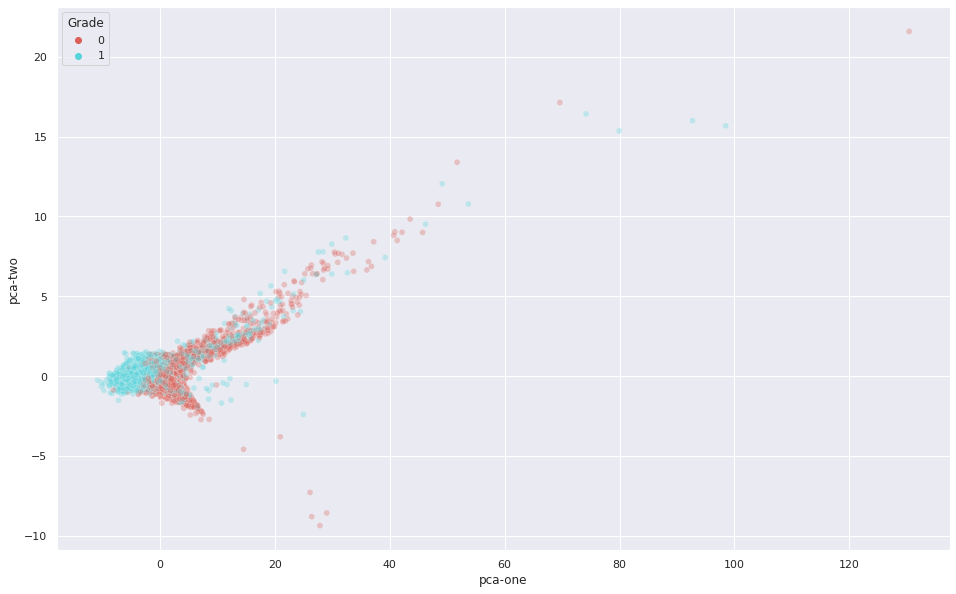

In [13]:
# PCA visualization using Scatterplot
# pca-one and pca-two component visualization
plt.figure(figsize=(16,10))
sns.scatterplot(
    x="pca-one", y="pca-two",
    hue="Grade",
    palette=sns.color_palette("hls", 2),
    data=df.loc[rndperm,:],
    legend="full",
    alpha=0.3
)

/tmp/ipykernel_272254/2131015794.py:2: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = plt.figure(figsize=(16,10)).gca(projection='3d')


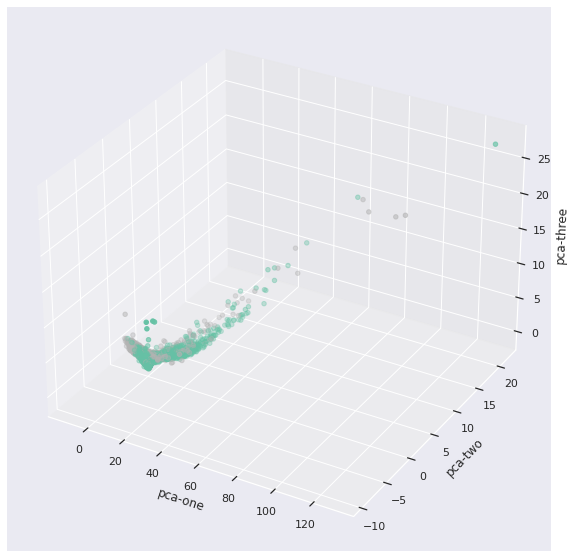

In [14]:

# Visualizing All Three PCA components
ax = plt.figure(figsize=(16,10)).gca(projection='3d')
ax.scatter(
    xs=df.loc[rndperm,:]["pca-one"], 
    ys=df.loc[rndperm,:]["pca-two"], 
    zs=df.loc[rndperm,:]["pca-three"], 
    c=df.loc[rndperm,:]["Grade"], 
    cmap='Set2'
)
ax.set_xlabel('pca-one')
ax.set_ylabel('pca-two')
ax.set_zlabel('pca-three')
plt.show()

### PCA and TSNE on a subset

In [15]:
N = 10000
# Selecting  A Subset of Samples for TSNE Visualization ( Randomly selecting N samples)
df_subset = df.loc[rndperm[:N],:].copy()
data_subset = df_subset[feat_cols].values
pca = PCA(n_components=3)
pca_result = pca.fit_transform(data_subset)
df_subset['pca-one'] = pca_result[:,0]
df_subset['pca-two'] = pca_result[:,1] 
df_subset['pca-three'] = pca_result[:,2]

TSNE on a subset of patches

In [16]:
time_start = time.time()
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(data_subset)
print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))
df_subset['tsne-2d-one'] = tsne_results[:,0]
df_subset['tsne-2d-two'] = tsne_results[:,1]

/mnt/largedrive0/katariap/feature_extraction/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/mnt/largedrive0/katariap/feature_extraction/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.019s...
[t-SNE] Computed neighbors for 10000 samples in 2.106s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 0.085052
[t-SNE] KL divergence after 250 iterations with early exaggeration: 71.807709
[t-SNE] KL divergence after 300 iterations: 2.267334
t-SNE done! Time elapsed:

## TSNE and PCA visualization for Subset of Samples

<AxesSubplot:xlabel='tsne-2d-one', ylabel='tsne-2d-two'>

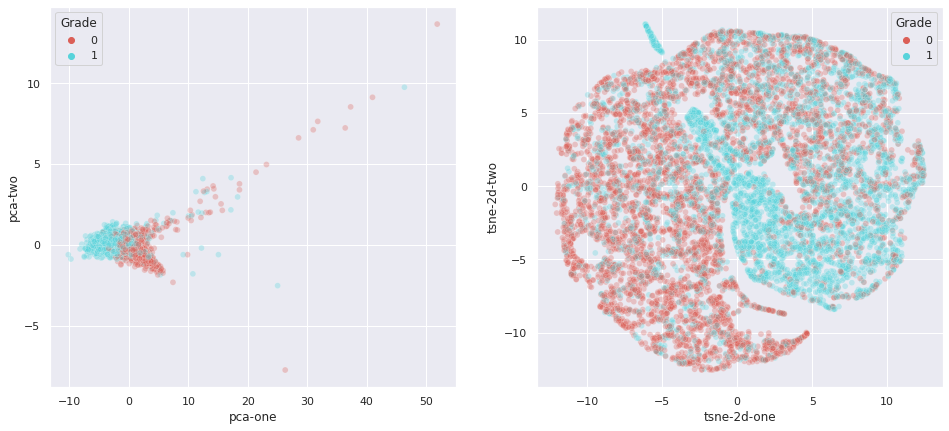

In [17]:
plt.figure(figsize=(16,7))
ax1 = plt.subplot(1, 2, 1)
sns.scatterplot(
    x="pca-one", y="pca-two",
    hue="Grade",
    palette=sns.color_palette("hls", 2),
    data=df_subset,
    legend="full",
    alpha=0.3,
    ax=ax1
)
ax2 = plt.subplot(1, 2, 2)
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="Grade",
    palette=sns.color_palette("hls",2),
    data=df_subset,
    legend="full",
    alpha=0.3,
    ax=ax2
)

## Using 10 PCA components and Then Performing TSNE

In [18]:
pca_10 = PCA(n_components=10)
pca_result_10 = pca_10.fit_transform(data_subset)
print('Cumulative explained variation for 10 principal components: {}'.format(np.sum(pca_10.explained_variance_ratio_)))

Cumulative explained variation for 10 principal components: 0.9992937445640564


In [19]:
time_start = time.time()
tsne = TSNE(n_components=2, verbose=0, perplexity=40, n_iter=300)
tsne_pca_results = tsne.fit_transform(pca_result_10)
print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))
df_subset['tsne-pca10-one'] = tsne_pca_results[:,0]
df_subset['tsne-pca10-two'] = tsne_pca_results[:,1]

/mnt/largedrive0/katariap/feature_extraction/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/mnt/largedrive0/katariap/feature_extraction/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


t-SNE done! Time elapsed: 25.108185529708862 seconds


Visualization of all Three Together.
1. PCA
2. TSNE
3. PCA + TSNE

<AxesSubplot:xlabel='tsne-pca10-one', ylabel='tsne-pca10-two'>

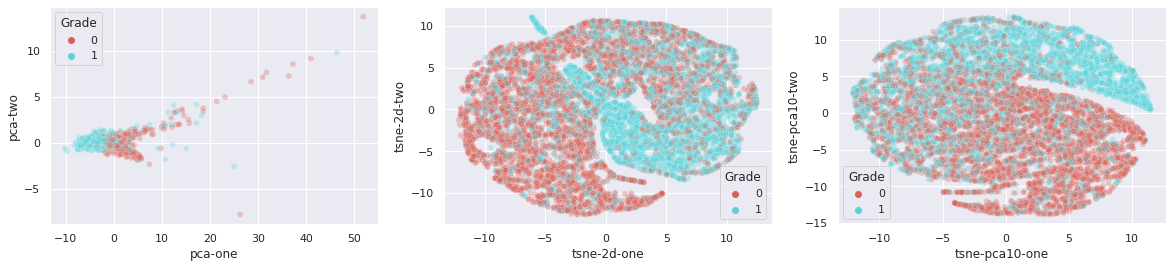

In [20]:

plt.figure(figsize=(20,4))
ax1 = plt.subplot(1, 3, 1)
sns.scatterplot(
    x="pca-one", y="pca-two",
    hue="Grade",
    palette=sns.color_palette("hls", 2),
    data=df_subset,
    legend="full",
    alpha=0.3,
    ax=ax1
)
ax2 = plt.subplot(1, 3, 2)
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="Grade",
    palette=sns.color_palette("hls", 2),
    data=df_subset,
    legend="full",
    alpha=0.3,
    ax=ax2
)
ax3 = plt.subplot(1, 3, 3)
sns.scatterplot(
    x="tsne-pca10-one", y="tsne-pca10-two",
    hue="Grade",
    palette=sns.color_palette("hls", 2),
    data=df_subset,
    legend="full",
    alpha=0.3,
    ax=ax3
)

## Clustering Image Patches On Basis of Extracted Features

In [4]:
file_dict = pd.read_pickle('/mnt/largedrive0/katariap/feature_extraction/data/Dataset/kimianet_features/FineTuned_Model_Features_dict.pickle')
df = pd.DataFrame(file_dict.items(),columns=['Name','Feature_Value'])
slide_data = {}
patch_list = df['Name'].to_list()
feature_list = df['Feature_Value'].to_list()

PCA And Kmeans Using sklearn library

In [25]:
pca = PCA(n_components=10,random_state=23)
pca.fit(feature_list)
values_transformed = pca.transform(feature_list)


number_of_clusters = 9  # Number of Clusters Can Be Changed
kmeans = KMeans(n_clusters=number_of_clusters)
kmeans.fit(values_transformed)

In [ ]:
data_frame = pd.DataFrame(patch_list,columns = ['filename'])
data_frame['Cluster'] = kmeans.labels_

In [9]:
clusters = {}
for file,cluster in zip(patch_list,kmeans.labels_):
    if cluster not in clusters.keys():
        clusters[cluster] = []
        clusters[cluster].append(file)
    else:
        clusters[cluster].append(file)

AttributeError: 'Kmeans' object has no attribute 'labels_'

In [ ]:
data_frame.to_csv('') #Change Path And file name to store the cluster file

### Using Faiss
Sklearn is very very slow.
Prefer Faiss

In [5]:
mat = faiss.PCAMatrix (1024, 500)
mat.train(np.array(feature_list).astype('float32'))
assert mat.is_trained
feature_values_transformed = mat.apply(np.array(feature_list).astype('float32'))

In [7]:
ncentroids = 9
niter = 20
verbose = True
kmeans = faiss.Kmeans(feature_values_transformed.shape[1], ncentroids, niter=niter, verbose=verbose)
kmeans.train(feature_values_transformed)

Sampling a subset of 2304 / 98000 for training
Clustering 2304 points in 500D to 9 clusters, redo 1 times, 20 iterations
  Preprocessing in 0.03 s
  Iteration 19 (1.50 s, search 0.99 s): objective=1857.75 imbalance=1.289 nsplit=0       


1857.7489013671875

In [8]:
D, I = kmeans.index.search(feature_values_transformed, 1)

In [10]:
clusters = {}
for i in range(len(patch_list)):
    if (I[i] not in list(clusters.keys())):
        
        clusters[I[i][0]] = [patch_list[i]]
    else:
        clusters[I[i][0]] = clusters[I[i][0]] + [patch_list[i]]

In [ ]:
#Cluster Visualization. Visualize the Clusters By Running This Cell. 
for number in range(ncentroids):

        fig = plt.figure(figsize = (30,30))
        files = clusters[number]

        if len(files) > 10:
            files = random.sample(files,10) # 10 Random Files are selected from each cluster. Each Run display Different Files
        for index,file in enumerate(files):
            plt.subplot(5,5,index+1)
            name = file.split('/')[-1]
            img = Image.open(file)
            img = np.array(img)
            plt.imshow(img)
            plt.axis('off')
            plt.title(name ,fontsize = 7)

## Visualization Of Deep Features
### Heatmaps produced from the correspondence of convolutional layers and deep features (DFs)

In [ ]:
## Model Initialization

In [ ]:
from torchvision.models.feature_extraction import create_feature_extractor

temp = Image.open('/content/Sample 156.vsi - 20x [x=16000,y=19000,w=1000,h=1000].png')
temp = data_transforms['val'](temp)

x = torch.rand(3, 3, 1000, 1000)
# return_nodes = {
#     "model.model.0.norm5": "conv2"
# }
return_nodes = {
        "model.flatten":"conv2"
}
temp = temp.unsqueeze(0)
model2 = create_feature_extractor(model, return_nodes=return_nodes)
intermediate_outputs = model2(temp)


In [ ]:
temp = Image.open('/content/Sample 156.vsi - 20x [x=14000,y=29000,w=1000,h=1000].png')
temp = data_transforms['val'](temp)

x = torch.rand(3, 3, 1000, 1000)
return_nodes = {
    "model.model.0.norm5": "conv2"
}
temp = temp.unsqueeze(0)
model2 = create_feature_extractor(model, return_nodes=return_nodes)
intermediate_outputs = model2(temp)

img = intermediate_outputs['conv2'][0][13].detach().numpy()
plt.imshow(img,cmap = 'hot')

img_orig = Image.open('/content/Sample 156.vsi - 20x [x=14000,y=29000,w=1000,h=1000].png')
img_orig = img_orig.resize(img.shape)
heatmap = img
heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)